# Introducción a la predicción de series temporales
Las series de tiempo son diferentes de los problemas de modelado predictivo de regresión y clasificación más tradicionales. La estructura temporal agrega un orden a las observaciones. Este orden impuesto significa que los supuestos importantes sobre la coherencia de esas observaciones deben manejarse específicamente.
El objetivo de la predicción de series temporales es realizar predicciones precisas sobre el futuro. En este Jupyter Notebook, nos centraremos en cómo realizar predicciones sobre problemas de series de tiempo univariadas utilizando las herramientas estándar del ecosistema Python. La librería Pandas en Python proporciona un excelente soporte integrado para datos de series de tiempo, mientras que Statsmodels es un módulo de Python que permite a los usuarios explorar datos, estimar modelos estadísticos y realizar pruebas estadísticas.

Descargue el conjunto de datos de Tasas de fondos federales efectivas del [sitio web de datos económicos de FRED](https://fred.stlouisfed.org/series/FEDFUNDS). La tasa de fondos federales es la tasa de interés a la que las instituciones de depósito intercambian fondos federales entre sí durante la noche. Nos centraremos en pronosticar los tipos de interés hasta la crisis financiera de 2008.

## Muchos otros modelos 

Existen variaciones de los modelos anteriores para incluir una componente de periodicidad (SARIMA), para incluir otras variables temporales no retrasadas (SARIMAX y todas las que terminen en X), para incluir múltiples descriptores temporales (retrasados) (VAR, VARMA, VARMAX), modelos de suavizado exponencial para predicción (SES, HWES), etc. Recomiendo [está página](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/) que los menciona y da ejemplos de implementación básica.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [3]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Datos

<h3 id="Load-and-Explore-Time-Series-Data">Cargar y explorar datos de series temporales<a class="anchor-link" href="#Load-and-Explore-Time-Series-Data">¶</a></h3>

In [4]:
# load dataset
dataframe = pd.read_csv('FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )

In [5]:
# display first few lines of a time series
dataframe.head()

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


#### Creando series temporales
Pandas representa conjuntos de datos de series de tiempo como una serie. Una serie es una matriz unidimensional con una etiqueta de tiempo para cada fila.

In [6]:
# create a time series
s = pd.Series(dataframe.unstack().values, index=dataframe.index)

In [8]:
s.head()

DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.07
1954-10-01   0.85
1954-11-01   0.83
dtype: float32

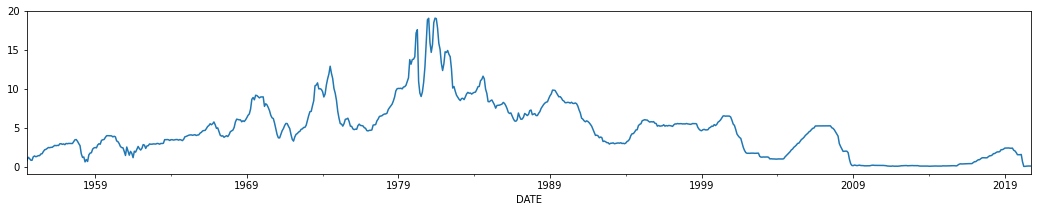

In [9]:
# basic plot
s.plot();

### Componentes de series temporales
Una abstracción útil para seleccionar métodos de forecasting es dividir una serie de tiempo en componentes sistemáticos y no sistemáticos.

- **Sistemático**: Componentes de la serie temporal que tienen consistencia o recurrencia y pueden
ser descritos y modelados.
- **No sistemático**: Componentes de la serie temporal que no pueden modelarse directamente.

Una serie de tiempo determinada puede verse como la unión de tres componentes sistemáticos, incluido el nivel,
tendencia, estacionalidad y un componente no sistemático llamado ruido. Estos componentes son
definido como sigue:

- **Nivel**: el valor medio de la serie.
- **Trend** (tendencia): El valor creciente o decreciente de la serie.
- **Seasonality** (periodicidad): El ciclo a corto plazo que se repite en la serie.
- **Ruido**: La variación aleatoria en la serie.

Nuestro conjunto de datos de series de tiempo puede contener una tendencia. Una tendencia (trend) es un aumento o disminución continuo en la serie a lo largo del tiempo. Puede resultar beneficioso identificar, modelar e incluso eliminar información de tendencias de un conjunto de datos de series de tiempo.
Los conjuntos de datos de series de tiempo pueden contener un componente de periodicidad (seasonality). Este es un ciclo que se repite con el tiempo, por ejemplo, mensual o anual. Este ciclo repetitivo puede 'oscurecer' la señal que deseamos modelar al realizar pronósticos y, a su vez, puede proporcionar una señal sólida para nuestros modelos predictivos. Hay muchos tipos de periodicidad: hora del día, diaria, semanal, mensual, anual, etc. Identificar si existe un componente de estacionalidad en su problema de serie temporal es
subjetivo. El enfoque más simple para determinar si existe un aspecto de estacionalidad es graficar y revisar los datos, quizás a diferentes escalas y con la adición de líneas de tendencia.

Una serie de tiempo en la que se ha eliminado el componente de periodicidad se denomina **seasonal stationary**. Si un conjunto de datos no tiene una tendencia o si la eliminamos con éxito, se dice que el conjunto de datos es **trend stationary**.

### Estacionariedad en datos de series temporales

Las observaciones en una serie de tiempo estacionaria no dependen del tiempo. Las series de tiempo son estacionarias
si no tienen efectos estacionales o de tendencia. Estadísticas resumidas calculadas sobre la serie temporal
son consistentes en el tiempo, como la media o la varianza de las observaciones. Cuando una serie de tiempo
es estacionario, puede ser más fácil de modelar. Los métodos de modelado estadístico asumen o requieren
las series de tiempo deben ser estacionarias para ser efectivas.

#### Verificar la estacionariedad
Hay muchos métodos para verificar si una serie de tiempo (observaciones directas, residuales, etc.) es estacionaria o no estacionaria.

- **Ver gráficos**: puede revisar un gráfico de series de tiempo de sus datos y verificar visualmente si hay tendencias obvias o periodicidad.
- **Estadísticas resumidas**: Puede revisar las estadísticas resumidas de sus datos para temporadas o particiones aleatorias y verificar diferencias obvias o significativas.
- **Pruebas estadísticas**: Puede utilizar pruebas estadísticas para comprobar si las expectativas de estacionariedad se cumplen o se han violado.

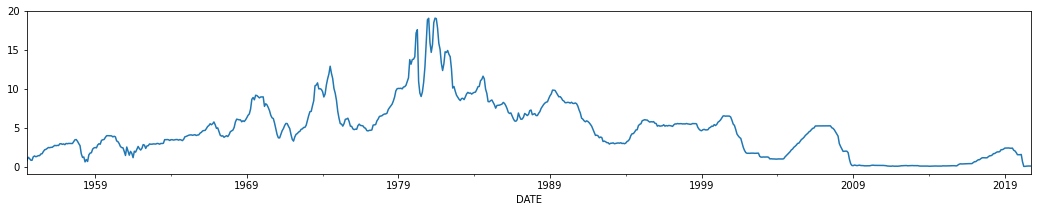

In [8]:
s.plot();

#### Augmented-Dickey-Fuller-test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

#### Prueba-Dickey-Fuller-aumentada
La prueba Augmented Dickey-Fuller es un tipo de prueba estadística llamada prueba de raíz unitaria. La intuición detrás de una prueba de raíz unitaria es que determina la fuerza con la que una serie de tiempo está definida por una tendencia. Utiliza un modelo autorregresivo y optimiza un criterio de información a través de múltiples valores de retardo diferentes. La hipótesis nula de la prueba es que la serie de tiempo se puede representar mediante una raíz unitaria, que no es estacionaria (tiene alguna estructura dependiente del tiempo). La hipótesis alternativa (que rechaza la hipótesis nula) es que la serie de tiempo es estacionaria.

In [10]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.627980
p-value: 0.087351
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Podemos ver que nuestro valor estadístico de -2,628 es menor que el valor de -2,569 al 10%%. Esto sugiere que podemos rechazar la hipótesis nula con un nivel de significancia de menos del 5% (es decir, una probabilidad baja de que el resultado sea una casualidad estadística). Rechazar la hipótesis nula significa que el proceso no tiene raíz unitaria y, a su vez, la serie de tiempo es estacionaria o no tiene una estructura dependiente del tiempo.

## Evaluate-Models

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using *train-test splits* and *k-fold cross-validation*, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.
In time series forecasting, this evaluation of models on historical data is called **backtesting**. We will look at three different methods that you can use to backtest your machine learning models on time series problems:

- **Train-Test split** that respects temporal order of observations.
- **Multiple Train-Test splits** that respect temporal order of observations.
- **Walk-Forward Validation** where a model may be updated each time step new data is received.

## Evaluar modelos

El objetivo de la predicción de series de tiempo es realizar predicciones precisas sobre el futuro. Los métodos rápidos y poderosos en los que confiamos en el aprendizaje automático, como el uso de *divisiones de train-test* y *k-fold cross-validation*, no funcionan en el caso de datos de series de tiempo. Esto se debe a que ignoran los componentes temporales inherentes al problema.
En el pronóstico de series de tiempo, esta evaluación de modelos sobre datos históricos se denomina **backtesting**. Veremos tres métodos diferentes que puede utilizar para realizar pruebas retrospectivas de sus modelos de aprendizaje automático en problemas de series de tiempo:

- **División train-test** que respeta el orden temporal de las observaciones.
- **Múltiples divisiones de train-test** que respetan el orden temporal de las observaciones.
- **Validación Walk-Forward** donde un modelo puede actualizarse cada vez que se reciben nuevos datos de paso.

### Train-Test Split

In [29]:
# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [30]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 796
Training Observations: 525
Testing Observations: 271


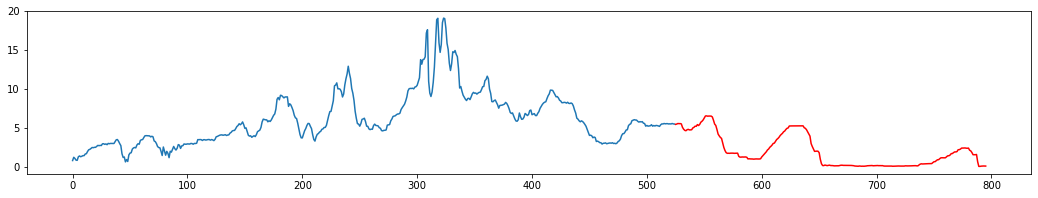

In [31]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

### Multiple Train-Test Splits

Podemos repetir el proceso de dividir la serie de tiempo en conjuntos de prueba y de entrenamiento varias veces. Esto requerirá entrenar y evaluar múltiples modelos, pero este gasto computacional adicional proporcionará una estimación más sólida del rendimiento esperado del método elegido y la configuración en datos no vistos. Podríamos hacer esto manualmente repitiendo las pruebas de tren dividido con diferentes puntos de división.

scikit-learn proporciona un "cross validator" de series de tiempo en el módulo `TimeSeriesSplit`. Proporciona índices de entrenamiento / prueba para dividir muestras de datos de series de tiempo que se observan a intervalos de tiempo fijos, en conjuntos de entrenamiento / prueba. Tenga en cuenta que, a diferencia de los métodos estándar de validación cruzada, los conjuntos de entrenamiento sucesivos son superconjuntos de los anteriores.

In [ ]:
# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 

El uso de múltiples divisiones train-test dará como resultado que se entrenen más modelos y, a su vez, una
estimación más precisa del rendimiento de los modelos en datos no vistos. Una limitación de la
El enfoque de división de tren-prueba es que los modelos entrenados permanecen fijos a medida que se evalúan en cada evaluación en el conjunto de prueba. Esto puede no ser realista, ya que los modelos pueden volver a capacitarse a medida que se disponga de nuevas observaciones diarias o mensuales.

### Walk Forward Validation

En la práctica, es muy probable que reentrenaremos nuestro modelo a medida que haya nuevos datos disponibles. Esto sería
Brinde al modelo la mejor oportunidad para hacer buenos pronósticos en cada paso de tiempo.
Hay pocas decisiones que tomar:

- **Número mínimo de observaciones**. Primero, debemos seleccionar el número mínimo de observaciones necesarias para entrenar el modelo. Esto se puede considerar como el ancho de la ventana si se usa una ventana deslizante (vea el siguiente punto).
- **Ventana deslizante o desplegable**. A continuación, debemos decidir si el modelo se entrenará con todos los datos que tiene disponibles o solo con las observaciones más recientes. Esto determina si se utilizará una ventana deslizante o expandible.

In [32]:
# walk forward validation: the train set expanding each time step
# and the test set fixed at one time step ahead
X = s[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=80, test=1
train=81, test=1
train=82, test=1
train=83, test=1
train=84, test=1
train=85, test=1
train=86, test=1
train=87, test=1
train=88, test=1
train=89, test=1
train=90, test=1
train=91, test=1
train=92, test=1
train=93, test=1
train=94, test=1
train=95, test=1
train=96, test=1
train=97, test=1
train=98, test=1
train=99, test=1


### Modelo de persistencia para la predicción
Establecer un baseline es esencial en cualquier problema de forecasting de series de tiempo. Un baseline del rendimiento da una idea de qué tan bien se desempeñarán realmente todos los demás modelos en el problema. Aquí desarrollaremos un modelo de persistencia que podremos usar más adelante como nivel de referencia de desempeño en el conjunto de datos de series de tiempo.
Se requieren los siguientes pasos:

- Transformar el conjunto de datos univariados en un problema de aprendizaje supervisado.
- Establecer los conjuntos de datos de entrenamiento y prueba para realizar el procedimiento.
- Definir el modelo de persistencia.
- Hacer una predicción y establecer el baseline de desempeño.
- Revisar el ejemplo completo y graficar la salida.

In [33]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
df.head()

,t,t+1
0,NaN,0.80
1,0.80,1.22
2,1.22,1.07
3,1.07,0.85
4,0.85,0.83


In [34]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [35]:
# persistence model
def model_persistence(x):
    return x

In [36]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [37]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.175


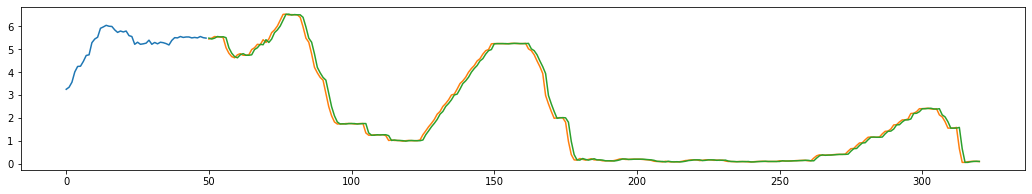

In [38]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions]);

### Visualize Residual Forecast Errors

Forecast errors on a time series forecasting problem are called *residual errors* or *residuals*. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.


In [39]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

La primera gráfica consiste en observar los errores de pronóstico residuales a lo largo del tiempo como una gráfica lineal. Esperaríamos que la gráfica fuera aleatoria alrededor del valor de 0 y no mostrara ninguna tendencia o estructura cíclica.

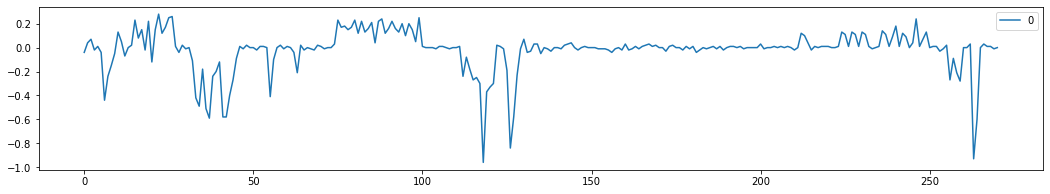

In [40]:
# plot residuals
residuals.plot();

Podemos calcular estadísticas resumidas sobre los errores residuales. Principalmente, estamos interesados ​​en
el valor medio de los errores residuales. Un valor cercano a cero sugiere que no hay sesgo en los pronósticos,
mientras que los valores positivos y negativos sugieren un sesgo positivo o negativo en las previsiones realizadas.
Es útil conocer un sesgo en los pronósticos, ya que puede corregirse directamente en los pronósticos antes
a su uso o evaluación.

In [41]:
residuals.describe()

,0
count,271.00
mean,-0.02
std,0.17
min,-0.96
25%,-0.02
50%,0.00
75%,0.03
max,0.28


Los gráficos se pueden utilizar para comprender mejor la distribución de errores más allá de las estadísticas de resumen.
Esperaríamos que los errores de pronóstico se distribuyeran normalmente alrededor de una media cero.

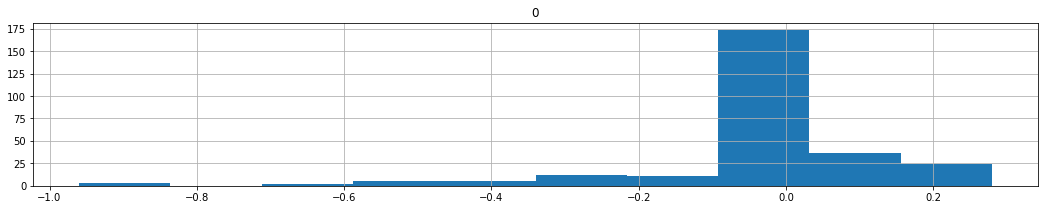

In [42]:
# histograms plot
residuals.hist();

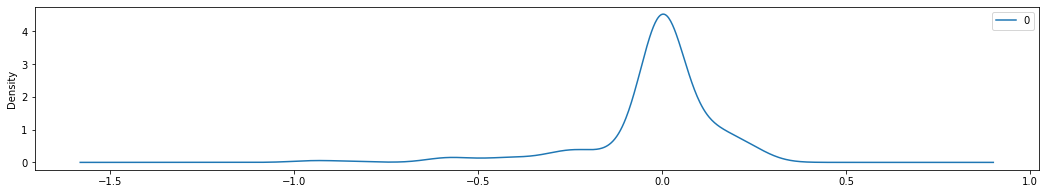

In [43]:
# density plot
residuals.plot(kind='kde');

#### Residual Q-Q Plot

Una gráfica Q-Q, o gráfica de cuantiles, compara dos distribuciones y se puede usar para ver qué tan similares o diferentes resultan ser. El gráfico Q-Q se puede utilizar para comprobar rápidamente la normalidad de la distribución de errores residuales. Los valores están ordenados y comparados con una distribución gaussiana idealizada. La comparación se muestra como un diagrama de dispersión (teórico en el eje xy observado en el eje y) donde una coincidencia entre las dos distribuciones se muestra como una línea diagonal desde la parte inferior izquierda hasta la parte superior derecha del gráfico.

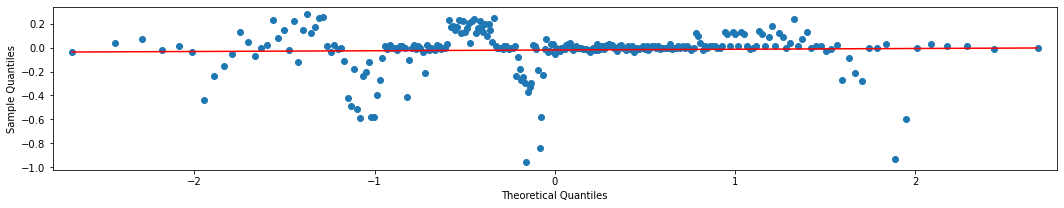

In [44]:
qqplot(residuals, line='r')
plt.show()

#### Residual Autocorrelation Plot

No esperaríamos que hubiera ninguna correlación entre los residuos. Esto se demostraría si los valores de autocorrelación están por debajo del umbral significativo (líneas horizontales discontinuas y punteadas en el gráfico). Una autocorrelación significativa en la gráfica residual sugiere que el modelo podría estar haciendo un mejor trabajo incorporando la relación entre observaciones y observaciones retrasadas, llamado *autorregresión*.

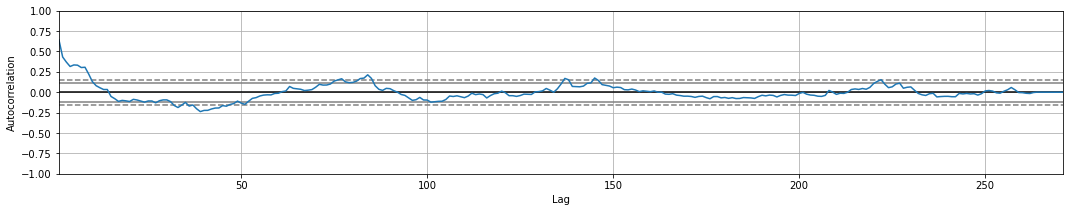

In [45]:
autocorrelation_plot(residuals);

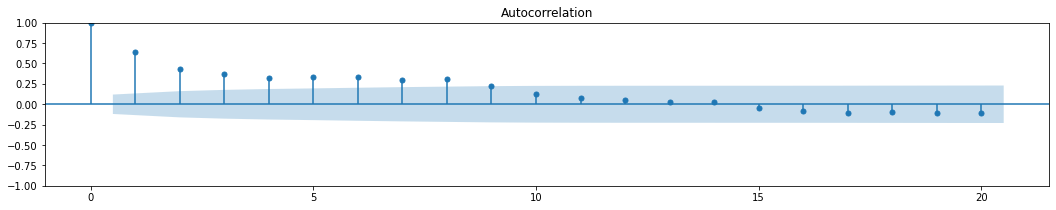

In [46]:
# autocorrelation plot of residuals as a line plot
plot_acf(residuals, lags=20)
plt.show()

### Replantear los problemas de predicción de series de tiempo
Hay muchas formas de reformular el problema de forecasting que pueden simplificar el problema de predicción y potencialmente exponer más o diferente información a modelar. Un replanteamiento puede resultar, en última instancia, en predicciones mejores y / o más sólidas.

### Replanteamientos de clasificación
La clasificación implica predecir resultados categóricos o de etiquetas (como *alto*, *medio* y *bajo*). Por ejemplo, podemos pronosticar si un cambio en el valor mínimo será pequeño o grande, o si el nuevo valor será menor o mayor que el valor actual.

In [2]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

NameError: name 'pd' is not defined

In [48]:
def make_discrete(row):
   if row['t+1'] < 0:
      return 'low'
   elif row['t+1'] > 3:
      return 'high'
   else:
      return 'medium'

In [49]:
# apply the above function to reassign t+1 values
df['t+1'] = df.apply(lambda row: make_discrete(row), axis=1)

In [50]:
# Randomly sample 10 elements from the dataframe
df.sample(n=10)

,t,t+1
746,0.40,medium
13,1.68,medium
569,2.09,medium
229,10.40,high
437,7.81,high
685,0.07,medium
397,6.58,high
362,11.64,high
396,6.73,high
678,0.18,medium


#### Replanteamientos del tiempo

- Pronosticar el valor mínimo para los próximos 3 meses.
- Pronosticar el valor máximo relativo a la media de los últimos 12 meses.
- Pronostique el mes del próximo año que tendrá el valor más bajo.

In [51]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values, values.shift(-1), values.shift(-2)], axis=1)
df.columns = ['t', 't+1', 't+2', 't+3']

In [52]:
df.head()

,t,t+1,t+2,t+3
0,NaN,0.80,1.22,1.07
1,0.80,1.22,1.07,0.85
2,1.22,1.07,0.85,0.83
3,1.07,0.85,0.83,1.28
4,0.85,0.83,1.28,1.39


Ahora podemos definir el problema como: dada la tasa de interés mínima del día anterior, pronosticar el valor mínimo para los próximos 3 días.

# Forecasting

Elegimos *el modelo persistente* como nuestro baseline de rendimiento de predicción y obtuvimos el error cuadrático medio de la raíz de **RMSE = 0.175**. Ahora nos gustaría mejorar este resultado.

### Modelo de autorregresión
La autorregresión es un modelo de series de tiempo que utiliza observaciones de pasos de tiempo anteriores como entrada a una ecuación de regresión para predecir el valor en el siguiente paso de tiempo. Es una idea muy simple que puede resultar en pronósticos precisos en una variedad de problemas de series de tiempo.

In [53]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

Un modelo de autorregresión supone que las observaciones en el momento actual y anterior
son útiles para predecir el valor en el siguiente paso de tiempo. Esta relación entre
las variables se llama correlación. Si ambas variables cambian en la misma dirección, esto se denomina *correlación positiva*. Si las variables se mueven en direcciones opuestas a medida que cambian los valores (por ejemplo, uno sube y el otro baja), entonces esto se llama *correlación negativa*.

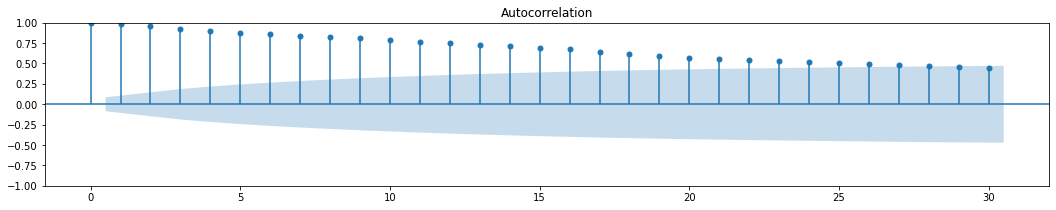

In [54]:
plot_acf(train, lags=30)
plt.show()

Un modelo de autorregresión es un modelo de regresión lineal que utiliza variables rezagadas como variables de entrada.
La librería de "Statsmodels" proporciona un modelo de autorregresión mediante la clase `autoReg` (que he renombrado como AR). Se puede seleccionar un valor automático de lags mediante [`statsmodels.tsa.ar_model.ar_select_order`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.ar_select_order.html?highlight=ar_select).

In [61]:
# train autoregression
model = AR(train,lags=18)
model_fit = model.fit()

In [62]:
print('Lag: %s' % model_fit.ar_lags)
print('Coefficients: %s' % model_fit.params)

Lag: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Coefficients: [ 0.13574389  1.39444019 -0.51387651  0.1068644  -0.0941412   0.08386943
  0.03140867 -0.21108618  0.32449151  0.01814261 -0.21089536 -0.01575069
 -0.00503123  0.23275888 -0.15955131  0.03444377  0.07140479 -0.15333591
  0.04469829]


#### Use-el-modelo-para-hacer-predicciones-para-una-semana

In [63]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [64]:
model_fit.predict?

In [65]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

predicted=5.518406, expected=5.450000
predicted=5.569895, expected=5.490000
predicted=5.599348, expected=5.560000
predicted=5.667830, expected=5.540000
predicted=5.693302, expected=5.550000
predicted=5.722688, expected=5.510000
predicted=5.760134, expected=5.070000


In [66]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.286


¡Esto es significativamente peor que el modelo de persistencia! ¿Cuál podría ser una posible razón?

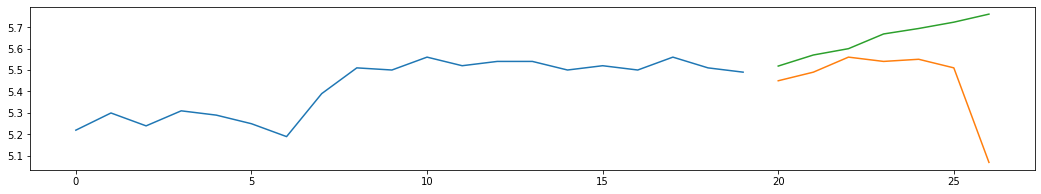

In [67]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]]);

Obviamente, queremos reconstruir el modelo después de cada día a medida que los nuevos datos estén disponibles.

##### Walk-Forward-Validation

La API <code>Statsmodels</code> no facilita la actualización del modelo a medida que aparecen nuevas observaciones. Una forma sería volver a entrenar el modelo AR todos los días a medida que se disponga de nuevas observaciones, y ese puede ser un enfoque válido, pero computacionalmente costoso. Una alternativa sería utilizar los coeficientes aprendidos y hacer predicciones manualmente. Esto requiere que se mantenga el historial de observaciones anteriores y que los coeficientes se recuperen del modelo y se utilicen en la ecuación de regresión para generar nuevos pronósticos.

In [68]:
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [74]:
# train autoregression
model = AR(train,lags=18)
model_fit = model.fit()
window = model_fit.ar_lags[-1]
coef = model_fit.params

In [75]:
window

18

In [76]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = []
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [77]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.185


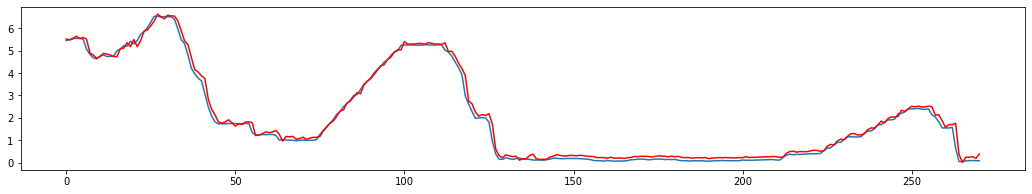

In [78]:
# plot
plt.plot(test)
plt.plot(predictions, color='red');

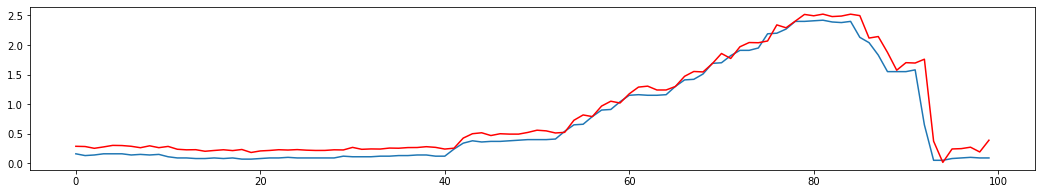

In [79]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Persistence-Forecast-Model

Repasemos los resultados del modelo de persistencia.

In [80]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [81]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [82]:
# persistence model
predictions = [x for x in test_X]

In [83]:
# skill of persistence model
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.175


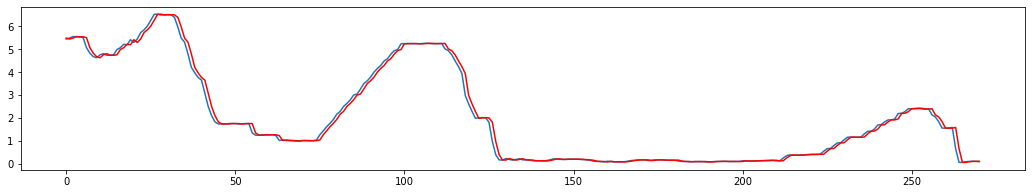

In [84]:
# plot
plt.plot(test_y)
plt.plot(predictions, color='red');

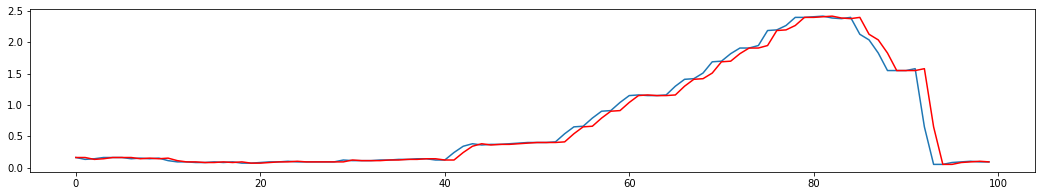

In [85]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Moving-Average-Models-for-Forecasting

La diferencia entre lo que se esperaba y lo que se predijo se llama **error residual**. Los errores residuales de los pronósticos en una serie de tiempo proporcionan otra fuente de información que podemos modelar. Los propios errores residuales forman una serie de tiempo que puede tener una estructura temporal.
Se puede usar un modelo de autorregresión simple de esta estructura para predecir el error de pronóstico, que a su vez se puede usar para corregir los pronósticos. Este tipo de modelo se denomina modelo de media móvil, el mismo nombre pero muy diferente del suavizado de media móvil.

#### Autoregression of Residual Error
We can model the residual error time series using an autoregression model. This is a linear
regression model that creates a weighted linear sum of lagged residual error terms.</p>
We can use the autoregression model (AR) provided by the <code>Statsmodels</code> library. Building on the persistence model (see the previous section), we can first train the model on the residual errors calculated on the training dataset.

#### Autoregresión de error residual
Podemos modelar la serie de tiempo de los errores residuales usando un modelo de autorregresión. Este es un 
modelo lineal de regresión que crea una suma lineal ponderada de términos de errores residuales retrasados.
Podemos usar el modelo de autorregresión (AR) proporcionado por `Statsmodels`. Sobre la base del modelo de persistencia primero podemos entrenar el modelo en los errores residuales calculados en el conjunto de datos de entrenamiento.

In [86]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
df.head()

,t,t+1
0,NaN,0.80
1,0.80,1.22
2,1.22,1.07
3,1.07,0.85
4,0.85,0.83


In [87]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [88]:
# persistence model on training set
train_pred = [x for x in train_X]

In [89]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [90]:
# model the training set residuals
model = AR(train_resid,lags=18)
model_fit = model.fit()
window = model_fit.ar_lags[-1]
coef = model_fit.params

In [91]:
print('Lag=%d, Coef=%s' % (window, coef))

Lag=18, Coef=[ 0.0042557   0.40854156 -0.10599049 -0.00090749 -0.09651765 -0.00613203
  0.01636806 -0.19382914  0.13528924  0.15858926 -0.05710992 -0.08388266
 -0.0786841   0.15403838 -0.00998329  0.02861369  0.09611871 -0.04132982
 -0.04454104]


El modelo de autorregresión requiere el error residual de los 17 pasos de tiempo anteriores. Por lo tanto, debemos tener estos valores a mano. A medida que avanzamos paso a paso por el conjunto de datos de prueba haciendo predicciones y estimando el error, podemos calcular el error residual real y actualizar los valores de retraso de la serie temporal del error residual (historial) para poder calcular el error en el siguiente paso de tiempo.

In [92]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions, expected_error = [], []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]

    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error=%f, expected error=%f' % (pred_error, error))

This is a walk forward forecast, or a rolling forecast, model. We end up with a time series
of the residual forecast error from the train dataset and a predicted residual error on the test dataset. We can plot these and get a quick idea of how skillful the model is at predicting residual error.

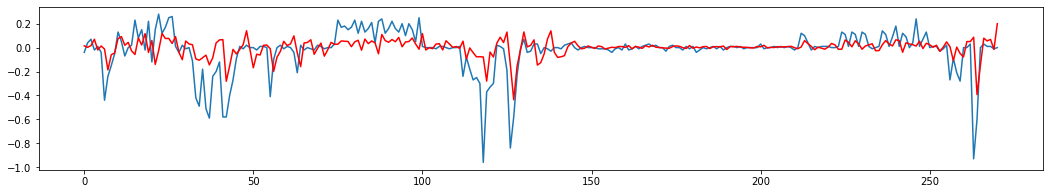

In [62]:
# plot predicted error
plt.plot(expected_error)
plt.plot(predictions, color='red')
plt.show()

#### Predicciones correctas con un modelo de residuos
Un modelo de error residual es interesante, pero también puede ser útil para mejorar las
predicciones. Con una buena estimación del error de predicción en un paso de tiempo, podemos mejorar las
predicciones. Por ejemplo, podemos agregar el error de predicción esperado a una predicción para corregirlo y, a su vez, mejorar la habilidad del modelo.

In [93]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [94]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [95]:
# persistence model on training set
train_pred = [x for x in train_X]

In [96]:
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

In [97]:
# model the training set residuals
model = AR(train_resid,lags=18)
model_fit = model.fit()

window = model_fit.ar_lags[-1]
coef = model_fit.params

In [98]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat

    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]

    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    #print('predicted=%f, expected=%f' % (yhat, test_y[t]))

# error
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [99]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.155


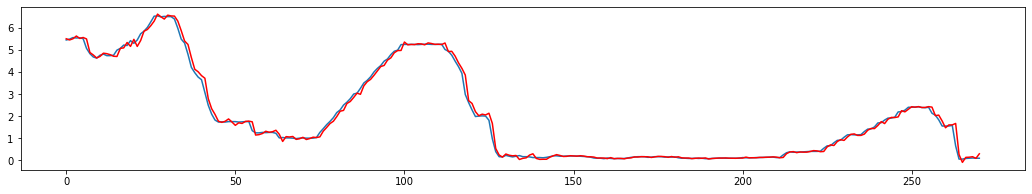

In [100]:
# plot predicted values
plt.plot(test_y)
plt.plot(predictions, color='red');

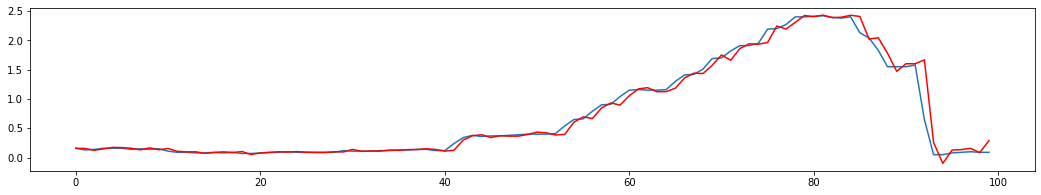

In [101]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Modelo ARIMA para previsión
    
El modelo ARIMA  es un modelo estadístico muy usado para el pronóstico y análisis de series de tiempo. 
ARIMA es un acrónimo de **Autoregressive Integrated Moving Average Model**. Este acrónimo es descriptivo y captura los aspectos clave del modelo en sí:

- **AR**: Autorregresión. Un modelo que usa la relación dependiente entre una observación y cierto número de observaciones retrasadas.
- **I**: Integrado. El uso de la diferenciación de observaciones en bruto (es decir, restar una observación de una observación en el paso de tiempo anterior) para hacer estacionaria la serie de tiempo.
- **MA**: Media móvil. Un modelo que utiliza la dependencia entre una observación y los errores residuales de un modelo de promedio móvil aplicado a observaciones retrasadas.

Los parámetros del modelo ARIMA se definen de la siguiente manera:

- **p**: El número de observaciones de retraso incluidas en el modelo, también llamado orden de retraso.
- **d**: El número de veces que se diferencian las observaciones sin procesar, también llamado grado de diferenciación.
- **q**: El tamaño de la ventana de la media móvil, también llamado orden de la media móvil.

Comencemos con algo simple. Adaptaremos un modelo ARIMA a todo el conjunto de datos y revisaremos los errores residuales. Primero, ajustamos un modelo `ARIMA (5,1,0)`. Esto establece el valor de retraso en 5 para la autorregresión, usa un orden de diferencia de 1 para hacer que la serie de tiempo sea estacionaria y usa un modelo de promedio móvil de 0.

In [105]:
# fit model
model = ARIMA(s, order=(5,1,0))
model_fit = model.fit()

In [106]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  796
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -494.732
Date:                Wed, 03 Nov 2021   AIC                           1001.464
Time:                        21:12:02   BIC                           1029.534
Sample:                    07-01-1954   HQIC                          1012.250
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4361      0.016     27.018      0.000       0.404       0.468
ar.L2         -0.1584      0.020     -8.077      0.000      -0.197      -0.120
ar.L3          0.0135      0.021      0.628      0.5

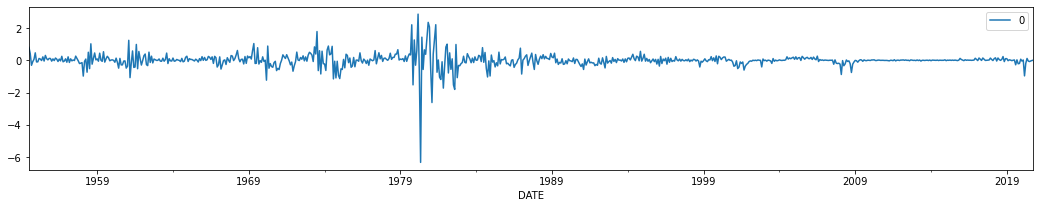

In [107]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

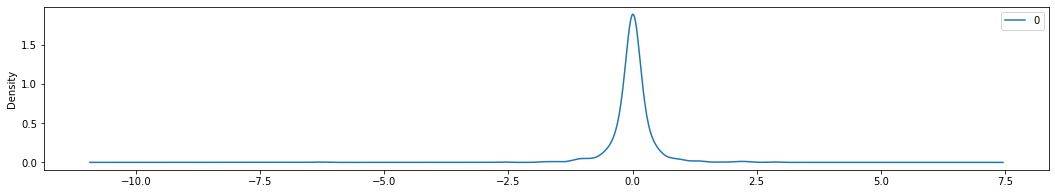

In [108]:
# density plot of residuals
residuals.plot(kind='kde');

[(-2.0, 2.0)]

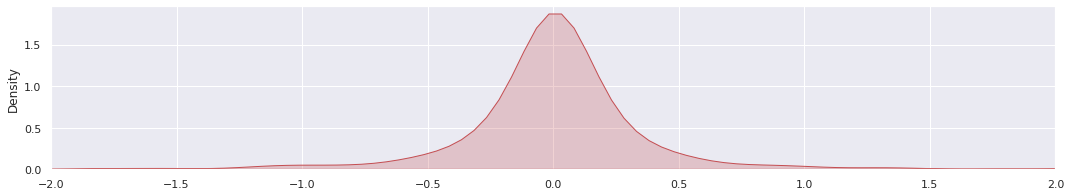

In [109]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

In [110]:
# summary stats of residuals
residuals.describe()

,0
count,796.00
mean,0.00
std,0.45
min,-6.33
25%,-0.09
50%,0.00
75%,0.11
max,2.86


#### Rolling Forecast ARIMA Model

Podemos dividir el conjunto de datos de entrenamiento en conjuntos de train-test, usar el conjunto de train para ajustar el modelo y generar una predicción para cada elemento en el conjunto de prueba.

In [111]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

Se requiere de una predicción continua (rolling) dada la dependencia de las observaciones en los pasos de tiempo anteriores para diferenciación y el modelo AR. Una forma burda de realizar este pronóstico continuo es volver a crear el modelo ARIMA después de recibir cada nueva observación. Realizamos un seguimiento manual de todas las observaciones en una lista llamada historial que se inserta con los datos de entrenamiento y a la que se agregan nuevas observaciones en cada iteración.

In [113]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

Podemos calcular una puntuación de error cuadrático medio final (RMSE) para las predicciones, proporcionando un punto de comparación con otras configuraciones ARIMA.

In [114]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.152


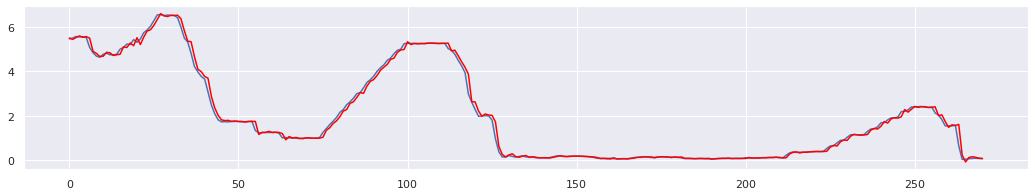

In [115]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

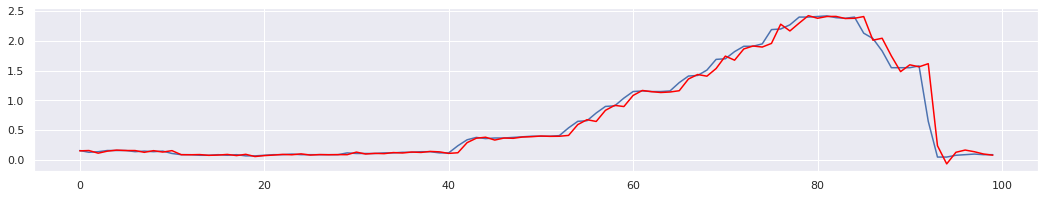

In [116]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

### Grid Search ARIMA Model Hyperparameters

In [118]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [119]:
# evaluate parameters
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(s.values, order)

0.14814488087298183

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(s.values, p_values, d_values, q_values)


<p>Sample Output:</p>
<pre><code>
ARIMA(0, 0, 0) RMSE=3.929
ARIMA(0, 0, 1) RMSE=2.031
ARIMA(0, 1, 0) RMSE=0.176
ARIMA(0, 1, 1) RMSE=0.146
ARIMA(1, 0, 0) RMSE=0.181
ARIMA(1, 0, 1) RMSE=0.155
ARIMA(1, 1, 0) RMSE=0.142
ARIMA(1, 1, 1) RMSE=0.144
ARIMA(2, 0, 0) RMSE=0.154
ARIMA(2, 0, 1) RMSE=0.154
ARIMA(2, 1, 0) RMSE=0.147
ARIMA(2, 1, 1) RMSE=0.154
Best ARIMA(1, 1, 0) RMSE=0.142
</code></pre>


#### Rolling Forecast with Selected ARIMA Model: Walk Forward Validation
<code>ARIMA(1, 1, 0)</code> performed best and we select it for our final model.

In [128]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [84]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [85]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.142


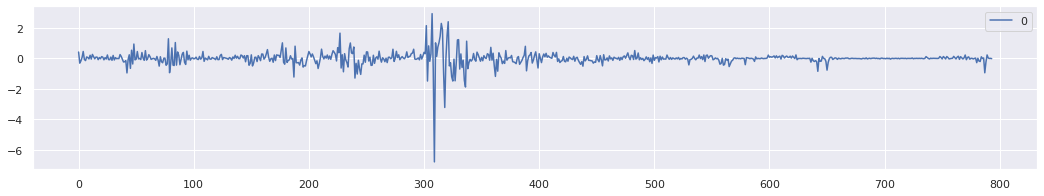

In [86]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

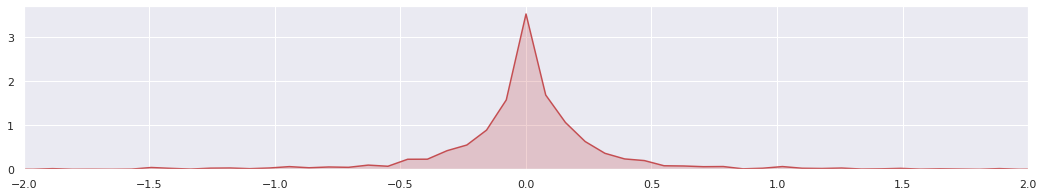

In [87]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2));

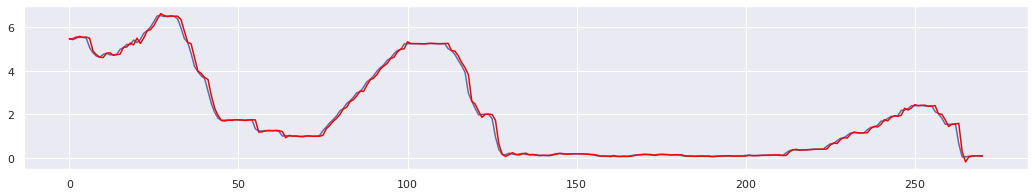

In [88]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

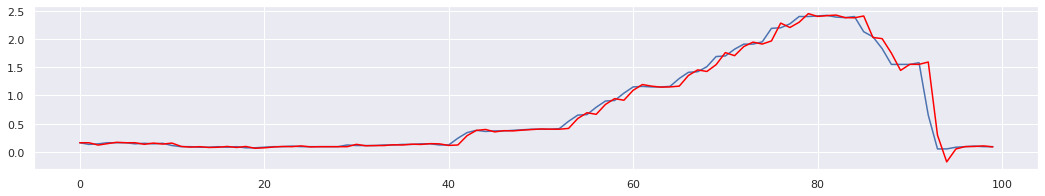

In [89]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

Let's just quickly review which part of the time series we were evaluating.

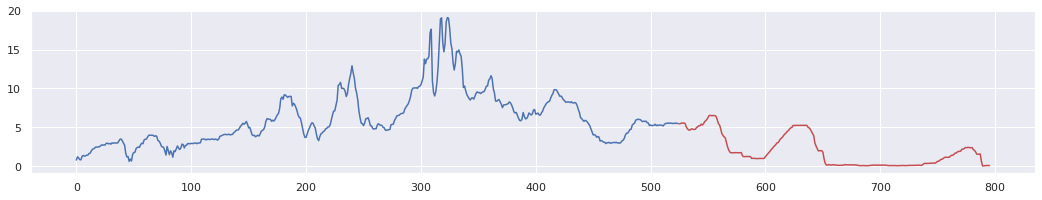

In [90]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

## Búsqueda de hiperparámetros usando `pdarima1

La librería pmdarima nos permite encontrar diversos hiperparámetros mediante búsquedas exhaustivas y mediante pruebas estadística. Esto es mucho más rápido que hacer FORs en python. Para instalar la librería basta con hacer 

``` pip install pmdarima ```

In [120]:
from pmdarima.arima import auto_arima

In [157]:
arima_model = auto_arima(history, start_p=0, start_q=0,
                             max_p=1, max_q=1,seasonal=False,
                             max_d=3, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False,)  # set to stepwise

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=951.753, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=864.357, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=876.610, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=865.917, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.399 seconds


In [159]:
arima_model.predict(n_periods=10)

array([5.5024108 , 5.51172123, 5.52103166, 5.53034209, 5.53965253,
       5.54896296, 5.55827339, 5.56758382, 5.57689425, 5.58620468,
       5.59551512, 5.60482555, 5.61413598, 5.62344641, 5.63275684,
       5.64206728, 5.65137771, 5.66068814, 5.66999857, 5.679309  ,
       5.68861944, 5.69792987, 5.7072403 , 5.71655073, 5.72586116,
       5.7351716 , 5.74448203, 5.75379246, 5.76310289, 5.77241332,
       5.78172375, 5.79103419, 5.80034462, 5.80965505, 5.81896548,
       5.82827591, 5.83758635, 5.84689678, 5.85620721, 5.86551764,
       5.87482807, 5.88413851, 5.89344894, 5.90275937, 5.9120698 ,
       5.92138023, 5.93069067, 5.9400011 , 5.94931153, 5.95862196,
       5.96793239, 5.97724282, 5.98655326, 5.99586369, 6.00517412,
       6.01448455, 6.02379498, 6.03310542, 6.04241585, 6.05172628,
       6.06103671, 6.07034714, 6.07965758, 6.08896801, 6.09827844,
       6.10758887, 6.1168993 , 6.12620974, 6.13552017, 6.1448306 ,
       6.15414103, 6.16345146, 6.17276189, 6.18207233, 6.19138

# Ejercicio

Para la serie temporal `AirPassengers.csv`:

1. Realice una exploración gráfica de la serie temporal (Line plot, density plot, boxplots, autocorrelation plots, etc.)
2. Construya una ventana de características (Window features) de: 
     a) 4 valores retrasados
     b) del mínimo, media, máximo, rango y desviación estándar para una ventana de tamaño 3 (retrasada)
3. Realice un moving average smoothing con una ventana de tamaño 5. Visualice el resultado.
4. ¿La serie es estacionaria?
5. Realice una división train-test 
6. Construya un modelo persistente como modelo de referencia sobre el train set. Evalue sobre el test set, revise los residuos. Concluya
7. Construya dos modelos de predicción usando regresión lineal usando las tablas del punto 2 sobre el train set, evalúe el resultado en el Test set y observe los residuos. Concluya
8. Construya un modelo de predicción usando moving average sobre el train set, evalue sobre el test set, revise los residuos. Concluya.    
  

9. Realice un modelo autoregresivo (`AR`) con el train set, y evalúe en el Test set. ¿Es mejor que el modelo persistente? Justifique.
10. Realice un modelo autoregresivo sobre los residuos del train set y utilicelos (usando walk forward) para corregir las predicciones de la variable respuesta sobre el test set. Evalue el desempeño. Grafique las predicciones y comparelas con los valores verdaderos.
11. Desarrolle un modelo ARIMA sobre el train set y evalúe el desempeño sobre el test set.
12. Desarrolle una búsqueda de los mejores hiperparámetros para el modelo ARIMA sobre el train set y evalúe el desempeño sobre el test set.